In [18]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import re
from collections import Counter

In [20]:
df = pd.read_csv('/Users/casey/Documents/GitHub/LLM_Healthcare/Radiology_cleaning/Rad_filtered_data_final_v5.csv')

critical_terms = {
    'emergency', 'urgent', 'critical', 'severe', 'acute', 'malignant', 'metastatic',
    'hemorrhage', 'rupture', 'failure', 'infarct', 'sepsis', 'abscess'
}

body_systems = {
    'cardiac', 'pulmonary', 'neurologic', 'gastrointestinal', 'musculoskeletal',
    'renal', 'hepatic', 'lymphatic', 'vascular', 'respiratory'
}

complex_conditions = {
    'mass', 'tumor', 'fracture', 'pneumonia', 'effusion', 'edema', 'lesion',
    'nodule', 'inflammation', 'infection', 'stenosis', 'thrombosis', 'embolism'
}

follow_up_terms = {
    'follow-up', 'follow up', 'monitoring', 'recommend', 'advised', 'correlation',
    'additional imaging', 'further evaluation', 'subsequent'
}


In [ ]:
def score_complexity(text):
    text = text.lower()
    
    score = 0
    
    # count unique terms from each category.
    critical_count = sum(1 for term in critical_terms if term in text)
    body_systems_count = sum(1 for term in body_systems if term in text)
    conditions_count = sum(1 for term in complex_conditions if term in text)
    follow_up_count = sum(1 for term in follow_up_terms if term in text)
    
    # score based on number of findings.
    findings = len(re.findall(r'(?:\d+\.|;|\n)\s*\w+', text))
    
    # calculate final score on a 1-10 scale.
    score += min(3, critical_count)
    score += min(2, body_systems_count)
    score += min(2, conditions_count / 2)
    score += min(1, follow_up_count)
    score += min(2, findings / 3)
    
    final_score = max(1, min(10, score * 2))
    
    # reasoning.
    reasons = []
    if critical_count > 0:
        reasons.append(f"Contains {critical_count} critical finding(s)")
    if body_systems_count > 0:
        reasons.append(f"Involves {body_systems_count} body system(s)")
    if conditions_count > 0:
        reasons.append(f"Has {conditions_count} complex condition(s)")
    if follow_up_count > 0:
        reasons.append("Requires follow-up")
    if findings > 0:
        reasons.append(f"Contains {findings} distinct finding(s)")
    
    reasoning = "; ".join(reasons) if reasons else "Basic case"
    
    return final_score, reasoning


In [ ]:
print("Preparing data.")
df['combined_text'] = df.apply(lambda x: f"Impression: {x['impression']}\nFindings: {x['findings']}", axis=1)

print(f"\nProcessing {len(df)} reports.")
results = []
for text in tqdm(df['combined_text']):
    score, reasoning = score_complexity(text)
    results.append((score, reasoning))

df['complexity_score'] = [r[0] for r in results]
df['complexity_reasoning'] = [r[1] for r in results]

complex_cases = df.nlargest(50000, 'complexity_score')

complex_cases.to_csv('complex_cases_50k.csv', index=False)
print(f"\nSaved {len(complex_cases)} complex cases to complex_cases_50k.csv")

print("\nComplexity score distribution:")
print(df['complexity_score'].value_counts().sort_index())

Preparing data...

Processing 226213 reports...


  0%|          | 0/226213 [00:00<?, ?it/s]


Saved 50000 complex cases to complex_cases_50k.csv

Complexity Score Distribution:
complexity_score
1.000000      7072
1.333333      1071
1.666667     19373
2.000000      1159
2.333333      1288
2.666667     13298
3.000000      1901
3.333333      1961
3.333333       222
3.666667     16072
4.000000      3126
4.333333      2689
4.333333       627
4.666667      1583
4.666667     12358
5.000000      4927
5.333333      1689
5.333333       916
5.666667      2091
5.666667      8246
6.000000      4908
6.333333      1670
6.333333      1372
6.666667      2329
6.666667      7011
7.000000      6419
7.333333      1471
7.333333      1552
7.666667      2526
7.666667      4460
8.000000      6824
8.333333      2959
8.666667      6182
9.000000      7468
9.333333      3109
9.666667      4334
10.000000    59950
Name: count, dtype: int64


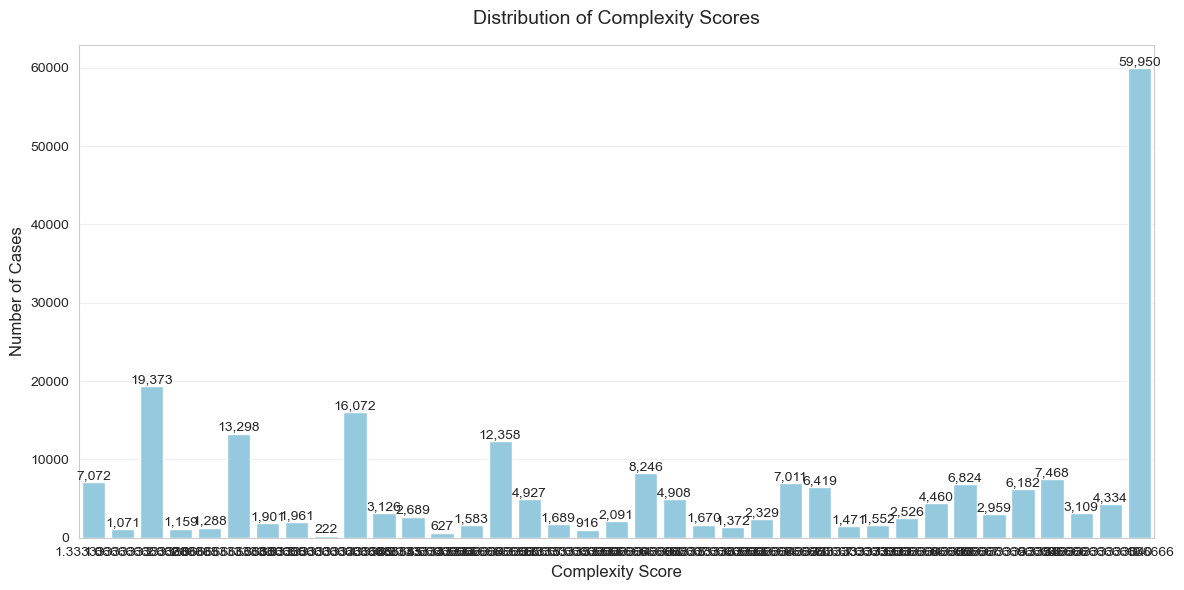


Summary Statistics:
count    226213.000000
mean          6.386076
std           3.068506
min           1.000000
25%           3.666667
50%           6.666667
75%          10.000000
max          10.000000
Name: complexity_score, dtype: float64


In [ ]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# bar plot.
score_counts = df['complexity_score'].value_counts().sort_index()
ax = sns.barplot(x=score_counts.index, y=score_counts.values, color='skyblue')

plt.title('Distribution of complexity scores', fontsize=14, pad=15)
plt.xlabel('Complexity score', fontsize=12)
plt.ylabel('Number of cases', fontsize=12)

for i, v in enumerate(score_counts.values):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.xticks(rotation=0)

plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()

plt.show()

print("\nSummary statistics:")
print(df['complexity_score'].describe())


In [ ]:
print("\nSample of highly complex cases:")
for _, row in complex_cases.nlargest(5, 'complexity_score').iterrows():
    print(f"\nScore: {row['complexity_score']}")
    print(f"Reasoning: {row['complexity_reasoning']}")
    print(f"Text: {row['impression'][:200]}...")
    print("-" * 80)



Sample of highly complex cases:

Score: 10.0
Reasoning: Contains 2 critical finding(s); Involves 1 body system(s); Has 2 complex condition(s); Contains 3 distinct finding(s)
Text: 1. Extensive chronic small vessel ischemic changes with superimposed lesion in the right corona radiata, which may represent a late subacute, resolving infarct. 2. Moderate age related parenchymal vol...
--------------------------------------------------------------------------------

Score: 10.0
Reasoning: Contains 1 critical finding(s); Involves 2 body system(s); Has 4 complex condition(s); Requires follow-up; Contains 8 distinct finding(s)
Text: 1. Segmental thickening of distal transverse colon with mild upstream dilatation visualized, appearance suspicious for acute colitis, correlation with patient's clinical history/physical exam and foll...
--------------------------------------------------------------------------------

Score: 10.0
Reasoning: Contains 1 critical finding(s); Involves 2 body system(s)